In [107]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns

Get Training, Validation, and Test Sets, making sure to normalize them separately as in https://gist.github.com/kevinzakka/d33bf8d6c7f06a9d8c76d97a7879f5cb :

In [ ]:
def get_train_valid_loader(data_dir, batch_size, random_seed, valid_size=0.1, shuffle=True, num_workers=4, pin_memory=False):
    #normalize mean and std based on internet search results for this specific dataset. For other datasets, calculate these inputs:
    normalize = transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010],)

    valid_transform = transforms.Compose([transforms.ToTensor(), normalize])
    train_transform = transforms.Compose([transforms.ToTensor(), normalize])

    train_dataset = torchvision.datasets.CIFAR10(root=data_dir, train=True, download=True, transform=train_transform)
    valid_dataset = torchvision.datasets.CIFAR10(root=data_dir, train=True, download=True, transform=valid_transform)

    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))

    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers, pin_memory=pin_memory)
    valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers, pin_memory=pin_memory)

    return (train_loader, valid_loader)

In [109]:
def get_test_loader(data_dir, batch_size, shuffle=True, num_workers=4, pin_memory=False):
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    transform = transforms.Compose([transforms.ToTensor(), normalize])
    dataset = torchvision.datasets.CIFAR10(root=data_dir, train=False, download=True, transform=transform)
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers, pin_memory=pin_memory)
    return data_loader

In [110]:
def train_and_validate(train_loader,val_loader,classes,optimizer,criterion,net,epochs):
    training_losses = []
    validation_losses = []
    true_labels = {}
    predicted_labels = {}
    training_accuracy = []
    validation_accuracy = []

    for epoch in range(epochs):  # loop over the dataset multiple times
        #Train:
        running_loss = 0.0
        train_correct = 0
        train_total = 0
        val_correct = 0
        val_total = 0
        batch_losses = []
        true_labels[epoch] = []
        predicted_labels[epoch] = []

        for inputs, labels in train_loader:
            # zero the parameter gradients:
            optimizer.zero_grad()

            # forward:
            outputs = net(inputs)

            #get epoch accuracy:
            _, predictions = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predictions == labels).sum().item()
            
            #backward:
            loss = criterion(outputs, labels)
            loss.backward()
            
            #optimize:
            optimizer.step()

            batch_losses.append(loss.item())

        train_loss = sum(batch_losses) / len(batch_losses)
        training_losses.append(train_loss)

        training_epoch_accuracy = train_correct/train_total
        training_accuracy.append(training_epoch_accuracy)

        #Validate:
        batch_losses = []
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = net(inputs)

                _, val_predictions = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (val_predictions == labels).sum().item()

                true_labels[epoch].extend(labels)
                predicted_labels[epoch].extend(val_predictions)

                loss = criterion(outputs, labels)
                batch_losses.append(loss.item())

        val_loss = sum(batch_losses) / len(batch_losses)
        validation_losses.append(val_loss)

        validation_epoch_accuracy = val_correct/val_total
        validation_accuracy.append(validation_epoch_accuracy)

        print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train accuracy: {training_epoch_accuracy:.4f}, Val accuracy: {validation_epoch_accuracy:.4f}')


    print('Finished Training')
    return true_labels, predicted_labels, training_losses, validation_losses, training_accuracy, validation_accuracy

In [119]:
def plot_learning_curves(epochs,train_accuracy,val_accuracy):
    plt.plot(range(1, epochs + 1), train_accuracy, label='Training Accuracy')
    plt.plot(range(1, epochs + 1), val_accuracy, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Learning Curves')
    plt.legend()
    plt.show()

In [112]:
def test(test_loader,net):
    dataiter = iter(test_loader)
    images, labels = next(dataiter)
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy on the test set is: {100 * correct // total} %')

In [113]:
def generate_confusion_matrices(filename_prefix, true_labels, predicted_labels, classes):
    for epoch in true_labels.keys():
        cm = confusion_matrix(true_labels[epoch],predicted_labels[epoch])
        cm_df = pd.DataFrame(cm,index=classes,columns=classes)
        plt.figure()
        sns.heatmap(cm_df,annot=True,fmt='d',cmap='Blues')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title('Confusion Matrix')
        plt.savefig(filename_prefix + '_cm_'+str(epoch)+'.png')

In [114]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2,stride=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(4096,256)
        self.fc2 = nn.Linear(256,10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool1(x)
        
        x = self.conv3(x)
        x = self.relu(x)
        x = self.conv4(x)
        x = self.relu(x)
        x = self.maxpool1(x)
        
        x = self.conv5(x)
        x = self.relu(x)
        x = self.conv6(x)
        x = self.relu(x)
        x = self.maxpool1(x)
        
        x = torch.flatten(x, start_dim=1,end_dim=3)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [115]:
net = Net()
epochs = 15
train_loader, val_loader = get_train_valid_loader('./data', batch_size=128, random_seed=42, valid_size=0.1, shuffle=True, num_workers=4, pin_memory=False)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [116]:
true_labels, predicted_labels, training_losses, validation_losses, training_accuracy, validation_accuracy = train_and_validate(train_loader,val_loader,classes,optimizer,criterion,net,epochs)

Epoch 1, Train Loss: 2.3027, Val Loss: 2.3031, Train accuracy: 0.1004, Val accuracy: 0.1006
Epoch 2, Train Loss: 2.3019, Val Loss: 2.3017, Train accuracy: 0.1142, Val accuracy: 0.1150
Epoch 3, Train Loss: 2.3003, Val Loss: 2.2989, Train accuracy: 0.1282, Val accuracy: 0.1526
Epoch 4, Train Loss: 2.2897, Val Loss: 2.2574, Train accuracy: 0.1782, Val accuracy: 0.1670
Epoch 5, Train Loss: 2.1059, Val Loss: 2.0009, Train accuracy: 0.2334, Val accuracy: 0.2582
Epoch 6, Train Loss: 1.9552, Val Loss: 1.9312, Train accuracy: 0.2868, Val accuracy: 0.2960
Epoch 7, Train Loss: 1.8509, Val Loss: 1.7813, Train accuracy: 0.3295, Val accuracy: 0.3438
Epoch 8, Train Loss: 1.7185, Val Loss: 1.6620, Train accuracy: 0.3741, Val accuracy: 0.3954
Epoch 9, Train Loss: 1.6245, Val Loss: 1.5649, Train accuracy: 0.4054, Val accuracy: 0.4146
Epoch 10, Train Loss: 1.5566, Val Loss: 1.5433, Train accuracy: 0.4323, Val accuracy: 0.4382
Epoch 11, Train Loss: 1.4896, Val Loss: 1.4887, Train accuracy: 0.4592, Val acc

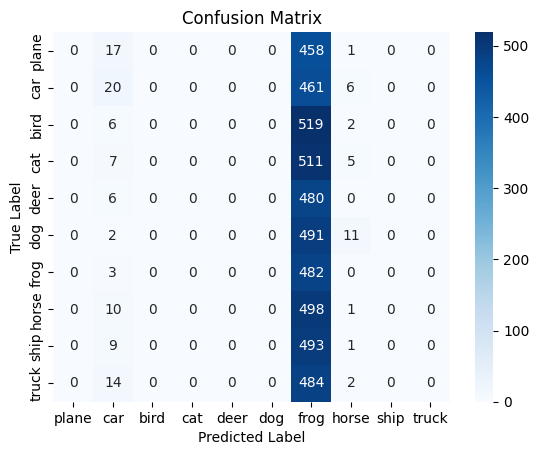

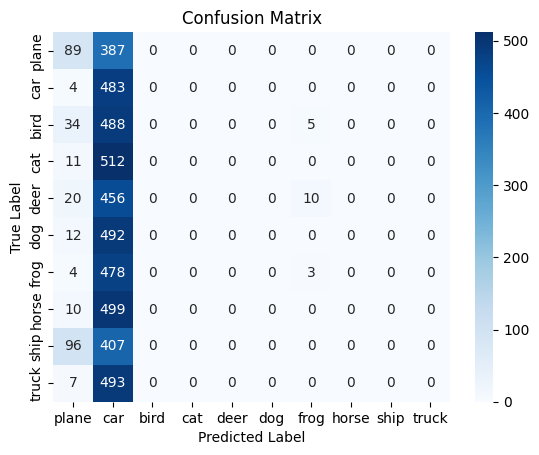

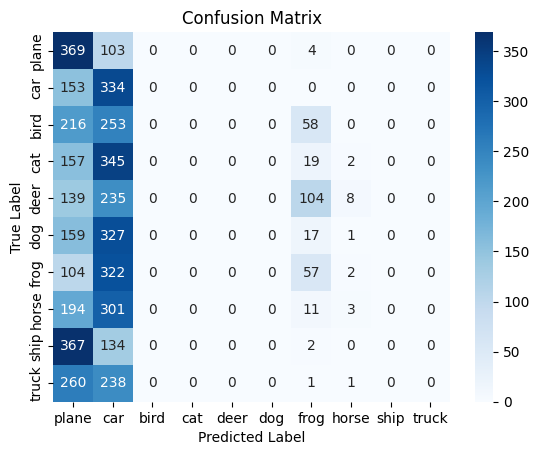

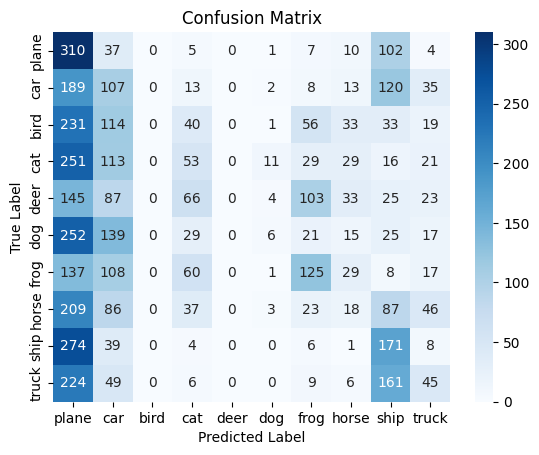

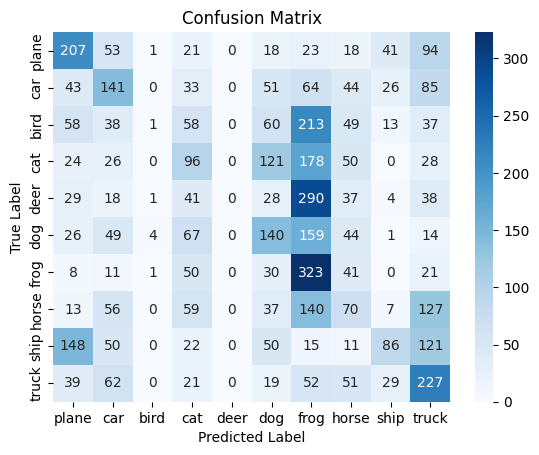

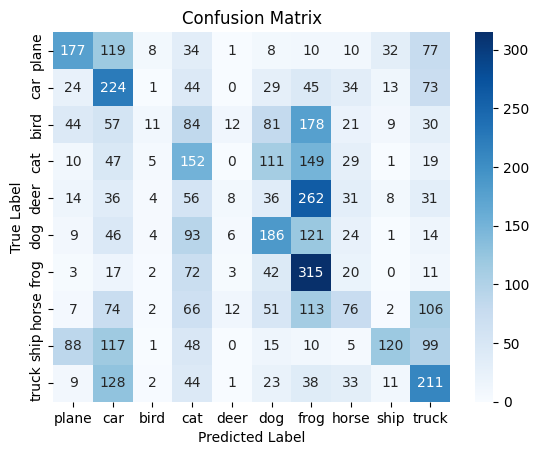

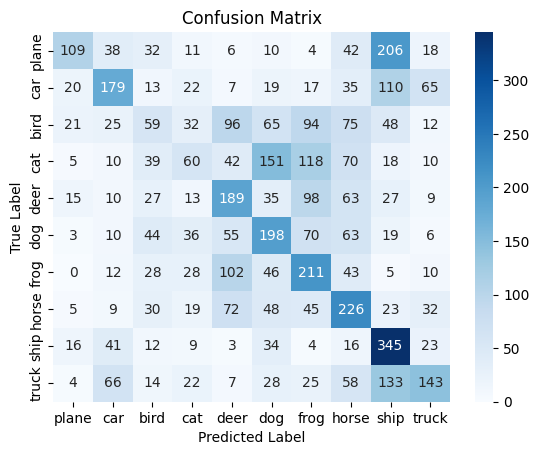

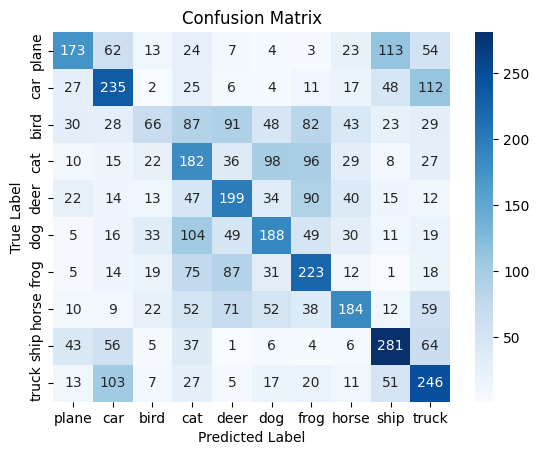

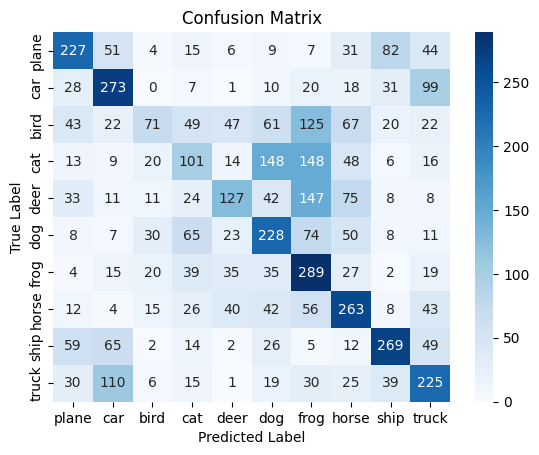

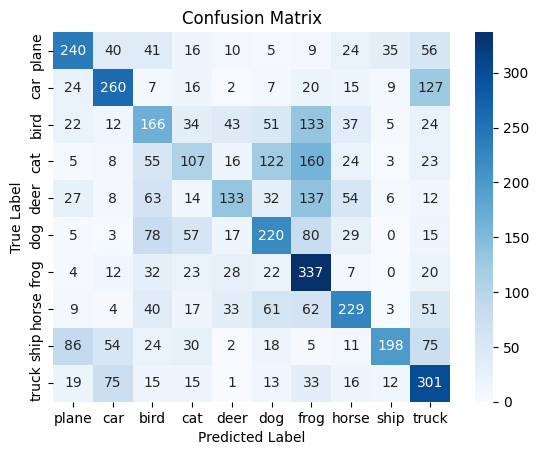

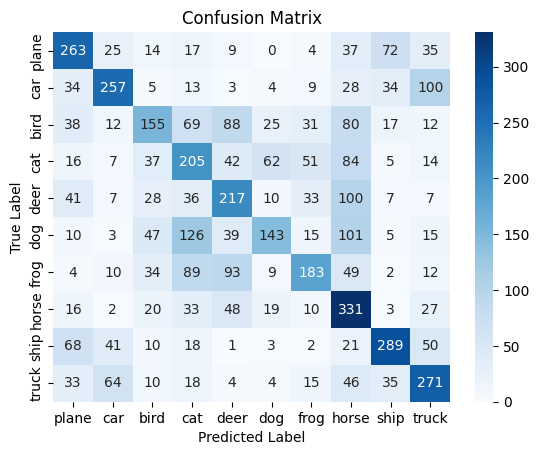

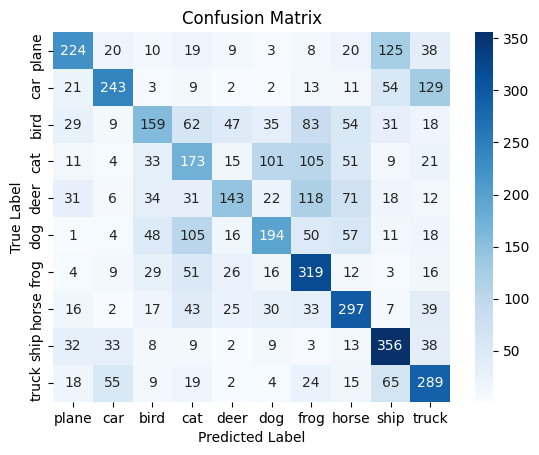

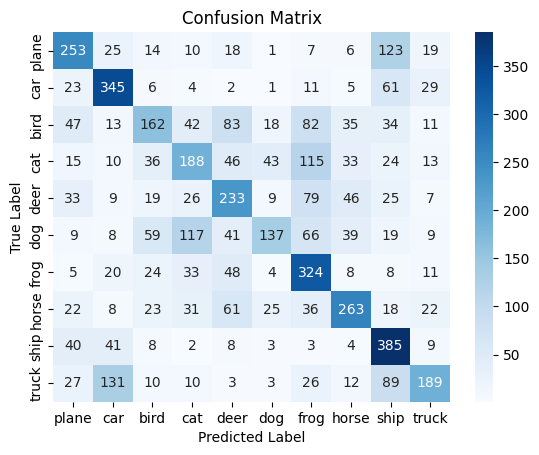

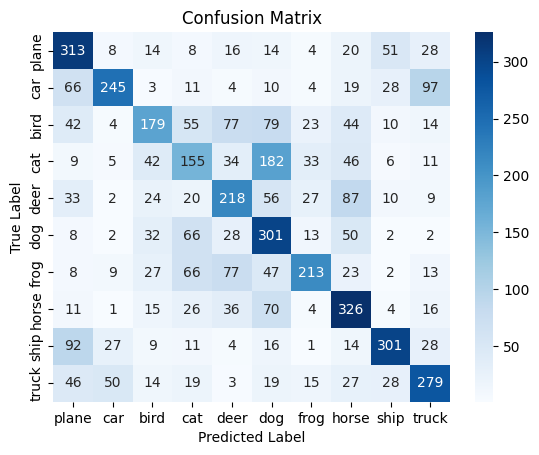

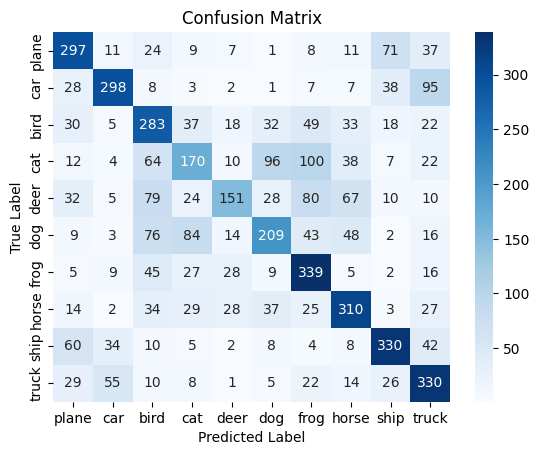

In [117]:
generate_confusion_matrices('first_model', true_labels, predicted_labels, classes)

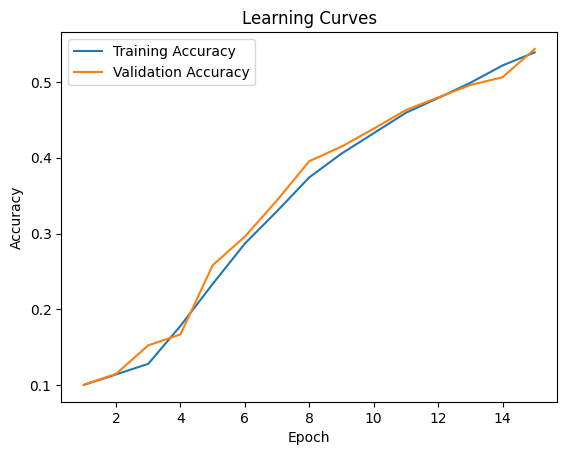

In [120]:
plot_learning_curves(epochs,training_accuracy,validation_accuracy)

In [121]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

Batch Normalization can both speed up learning and act as a sort of regularizer. For these reasons, let's add BatchNorm layers after each Max Pool layer:

In [122]:
class Net2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2,stride=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(4096,256)
        self.fc2 = nn.Linear(256,10)
        self.batchnorm1 = nn.BatchNorm2d(num_features=64)
        self.batchnorm2 = nn.BatchNorm2d(num_features=128)
        self.batchnorm3 = nn.BatchNorm2d(num_features=256)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool1(x)
        x = self.batchnorm1(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.conv4(x)
        x = self.relu(x)
        x = self.maxpool1(x)
        x = self.batchnorm2(x)
        x = self.conv5(x)
        x = self.relu(x)
        x = self.conv6(x)
        x = self.relu(x)
        x = self.maxpool1(x)
        x = self.batchnorm3(x)
        x = torch.flatten(x, start_dim=1,end_dim=3)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [123]:
net2 = Net2()
epochs = 15
train_loader2, val_loader2 = get_train_valid_loader('./data', batch_size=128, random_seed=42, valid_size=0.1, shuffle=True, num_workers=4, pin_memory=False)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
criterion2 = nn.CrossEntropyLoss()
optimizer2 = optim.SGD(net2.parameters(), lr=0.001, momentum=0.9)

In [124]:
true_labels2, predicted_labels2, training_losses2, validation_losses2, training_accuracy2, validation_accuracy2 = train_and_validate(train_loader2,val_loader2,classes,optimizer2,criterion2,net2,epochs)

Epoch 1, Train Loss: 1.4587, Val Loss: 1.1688, Train accuracy: 0.4791, Val accuracy: 0.5716
Epoch 2, Train Loss: 0.9892, Val Loss: 0.9132, Train accuracy: 0.6502, Val accuracy: 0.6710
Epoch 3, Train Loss: 0.7612, Val Loss: 0.7794, Train accuracy: 0.7346, Val accuracy: 0.7222
Epoch 4, Train Loss: 0.5979, Val Loss: 0.7289, Train accuracy: 0.7969, Val accuracy: 0.7360
Epoch 5, Train Loss: 0.4597, Val Loss: 0.6925, Train accuracy: 0.8493, Val accuracy: 0.7594
Epoch 6, Train Loss: 0.3310, Val Loss: 0.6883, Train accuracy: 0.8979, Val accuracy: 0.7622
Epoch 7, Train Loss: 0.2115, Val Loss: 0.7116, Train accuracy: 0.9444, Val accuracy: 0.7614
Epoch 8, Train Loss: 0.1155, Val Loss: 0.7478, Train accuracy: 0.9779, Val accuracy: 0.7666
Epoch 9, Train Loss: 0.0513, Val Loss: 0.7356, Train accuracy: 0.9957, Val accuracy: 0.7726
Epoch 10, Train Loss: 0.0227, Val Loss: 0.7455, Train accuracy: 0.9994, Val accuracy: 0.7830
Epoch 11, Train Loss: 0.0127, Val Loss: 0.7600, Train accuracy: 1.0000, Val acc

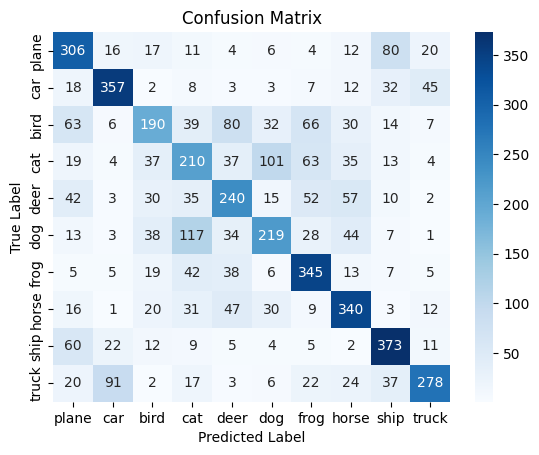

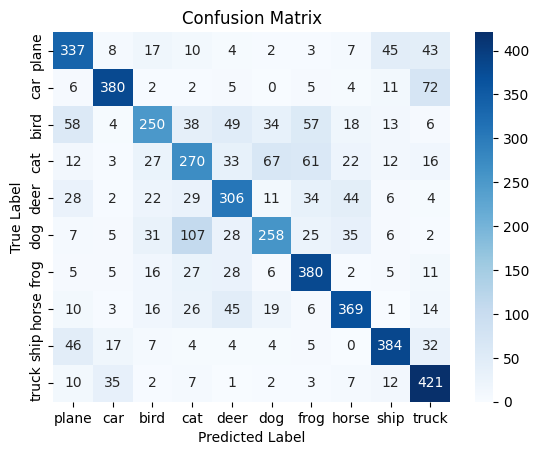

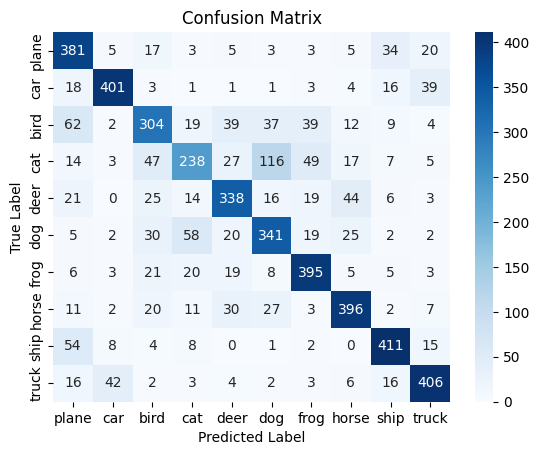

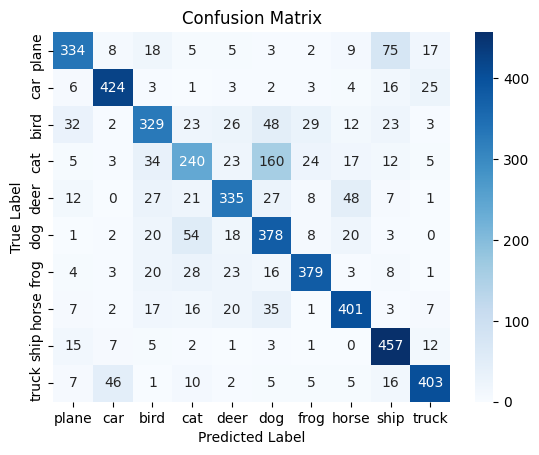

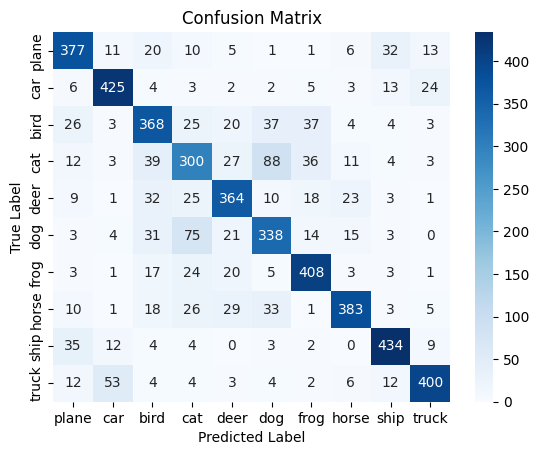

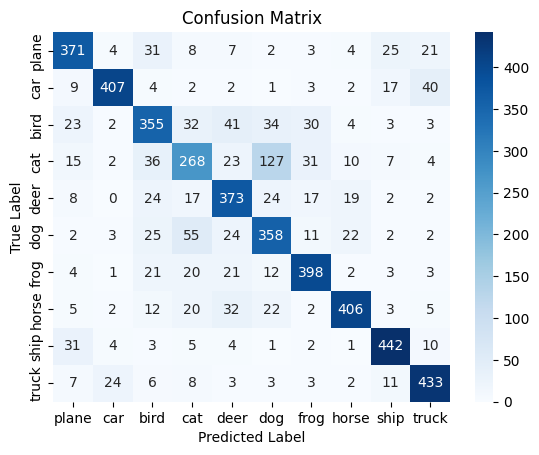

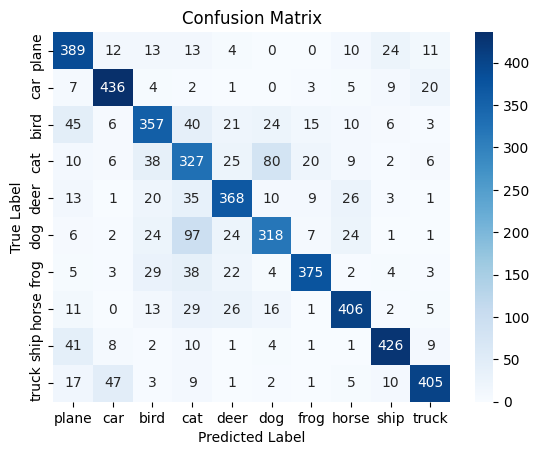

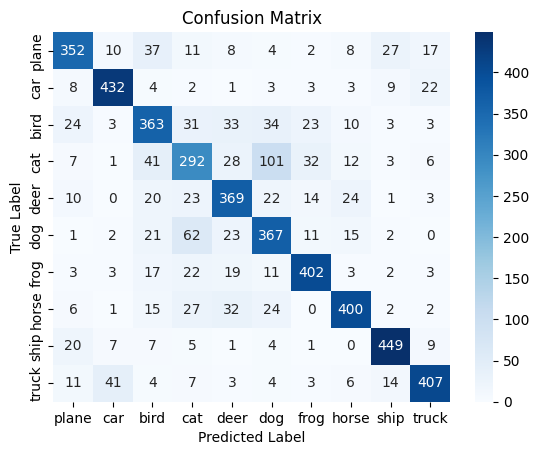

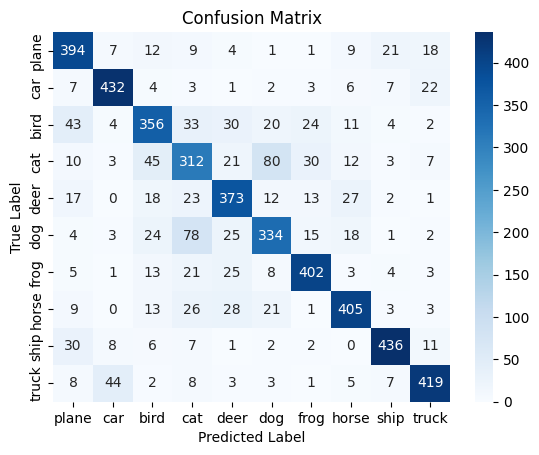

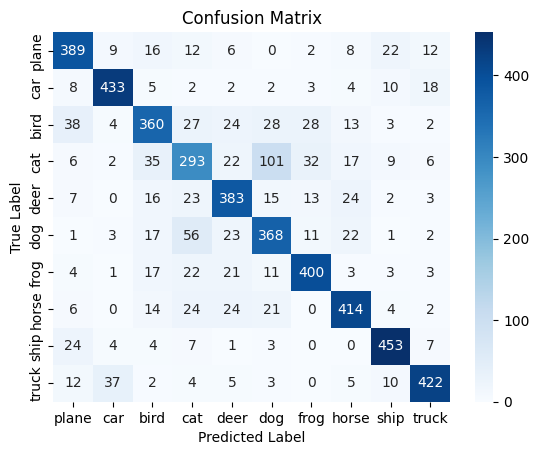

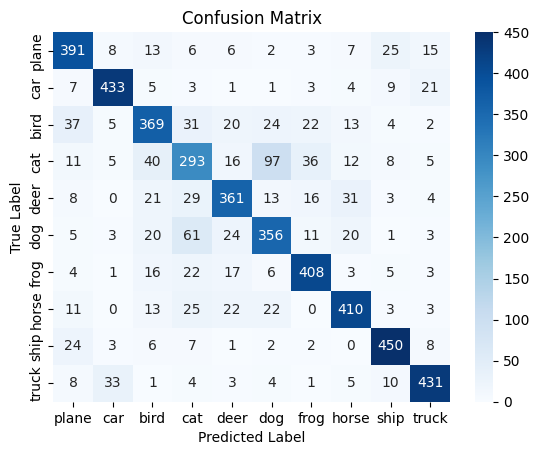

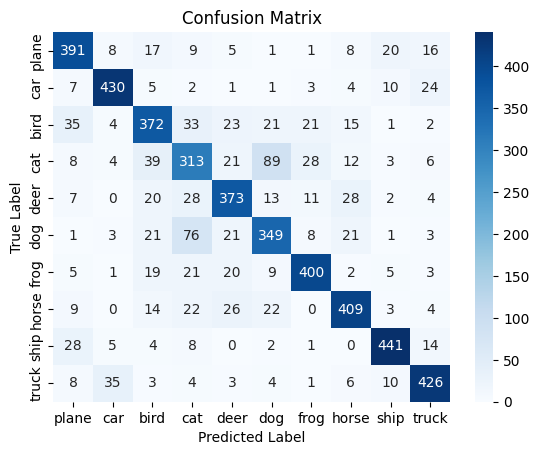

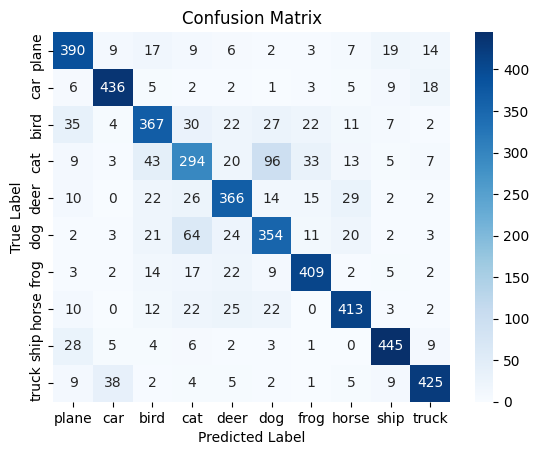

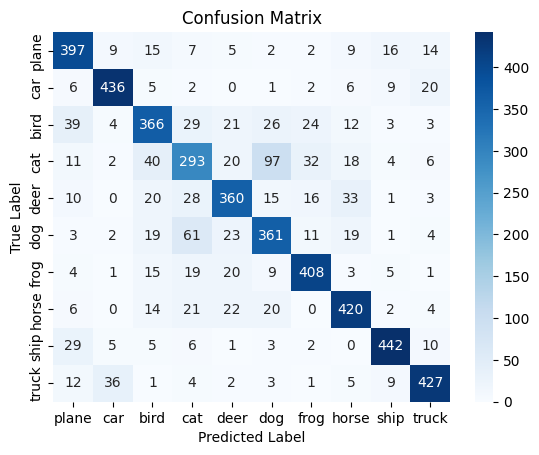

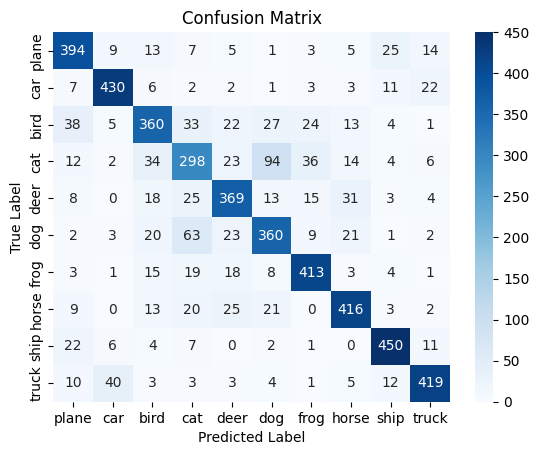

In [125]:
generate_confusion_matrices('second_model', true_labels2, predicted_labels2, classes)

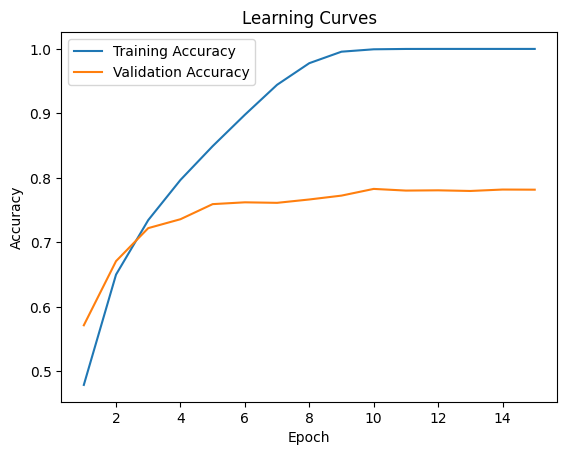

In [126]:
plot_learning_curves(epochs,training_accuracy2,validation_accuracy2)

In [127]:
PATH = './cifar_net2.pth'
torch.save(net2.state_dict(), PATH)

This validation accuracy is still not as high as I would like it to be. Let's try performing some transformations on the training data to help it generalize better:

In [130]:
def get_train_valid_loader(data_dir, batch_size, random_seed, valid_size=0.1, shuffle=True, num_workers=4, pin_memory=False):
    #normalize mean and std based on internet search results for this specific dataset. For other datasets, calculate these inputs:
    normalize = transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010],)

    valid_transform = transforms.Compose([transforms.ToTensor(), normalize])
    #Add random crop and random flip to training transformation:
    train_transform = transforms.Compose([transforms.RandomCrop(32, padding=4),transforms.RandomHorizontalFlip(),transforms.ToTensor(), normalize])

    train_dataset = torchvision.datasets.CIFAR10(root=data_dir, train=True, download=True, transform=train_transform)
    valid_dataset = torchvision.datasets.CIFAR10(root=data_dir, train=True, download=True, transform=valid_transform)

    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))

    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers, pin_memory=pin_memory)
    valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers, pin_memory=pin_memory)

    return (train_loader, valid_loader)

In [131]:
net3 = Net2()
epochs = 15
train_loader3, val_loader3 = get_train_valid_loader('./data', batch_size=128, random_seed=42, valid_size=0.1, shuffle=True, num_workers=4, pin_memory=False)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
criterion3 = nn.CrossEntropyLoss()
optimizer3 = optim.SGD(net3.parameters(), lr=0.001, momentum=0.9)

In [132]:
true_labels3, predicted_labels3, training_losses3, validation_losses3, training_accuracy3, validation_accuracy3 = train_and_validate(train_loader3,val_loader3,classes,optimizer3,criterion3,net3,epochs)

Epoch 1, Train Loss: 1.5868, Val Loss: 1.2951, Train accuracy: 0.4248, Val accuracy: 0.5326
Epoch 2, Train Loss: 1.1804, Val Loss: 1.0317, Train accuracy: 0.5755, Val accuracy: 0.6330
Epoch 3, Train Loss: 0.9723, Val Loss: 0.8736, Train accuracy: 0.6584, Val accuracy: 0.6962
Epoch 4, Train Loss: 0.8418, Val Loss: 0.7810, Train accuracy: 0.7031, Val accuracy: 0.7214
Epoch 5, Train Loss: 0.7544, Val Loss: 0.7528, Train accuracy: 0.7346, Val accuracy: 0.7368
Epoch 6, Train Loss: 0.6815, Val Loss: 0.6784, Train accuracy: 0.7606, Val accuracy: 0.7648
Epoch 7, Train Loss: 0.6338, Val Loss: 0.6345, Train accuracy: 0.7780, Val accuracy: 0.7814
Epoch 8, Train Loss: 0.5811, Val Loss: 0.6178, Train accuracy: 0.7961, Val accuracy: 0.7920
Epoch 9, Train Loss: 0.5471, Val Loss: 0.5983, Train accuracy: 0.8112, Val accuracy: 0.7964
Epoch 10, Train Loss: 0.5138, Val Loss: 0.5974, Train accuracy: 0.8228, Val accuracy: 0.7990
Epoch 11, Train Loss: 0.4825, Val Loss: 0.5314, Train accuracy: 0.8329, Val acc

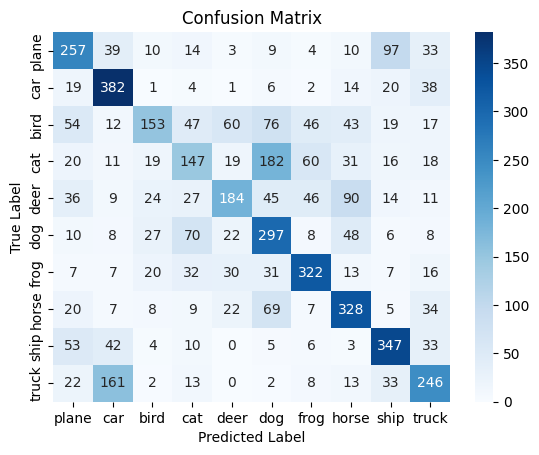

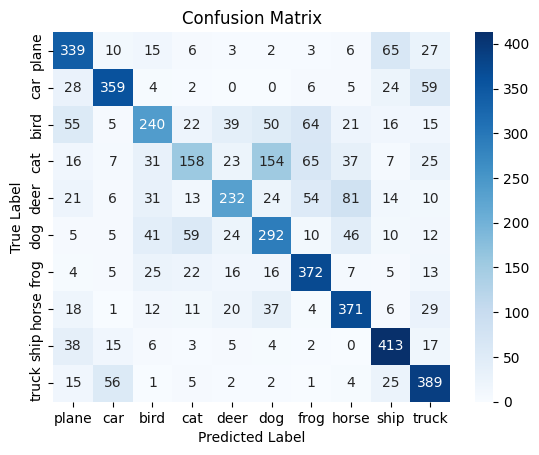

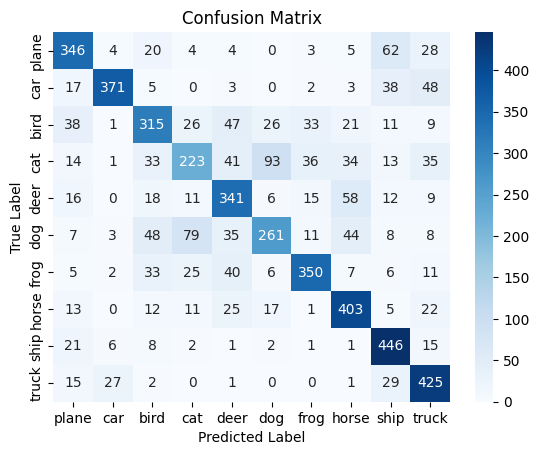

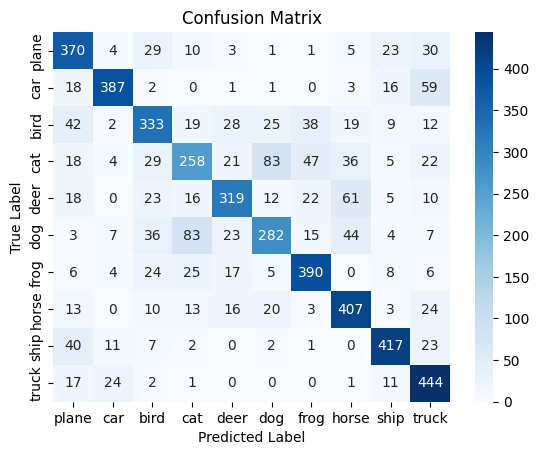

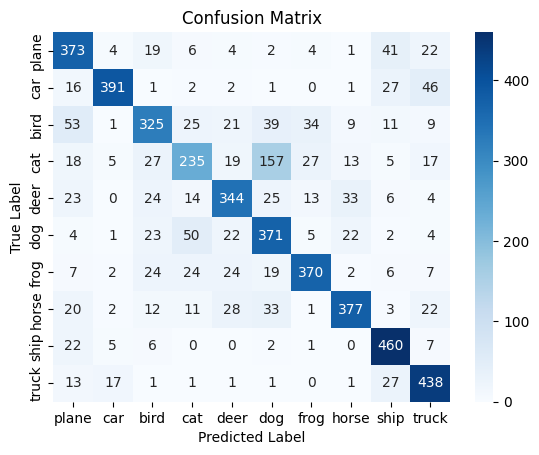

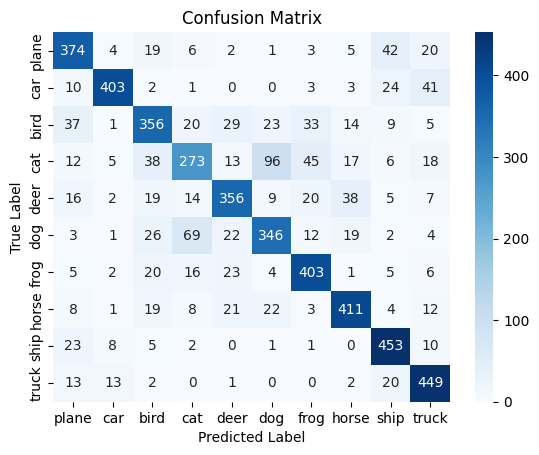

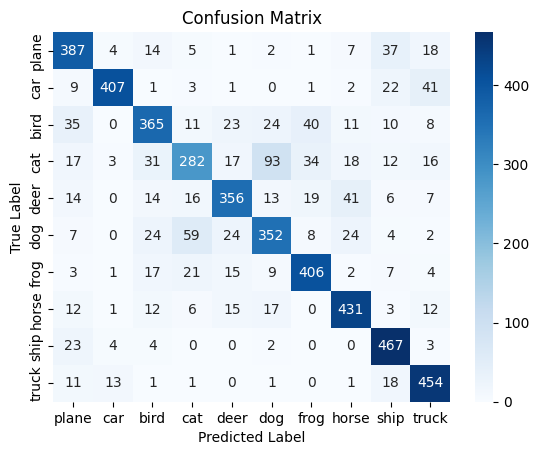

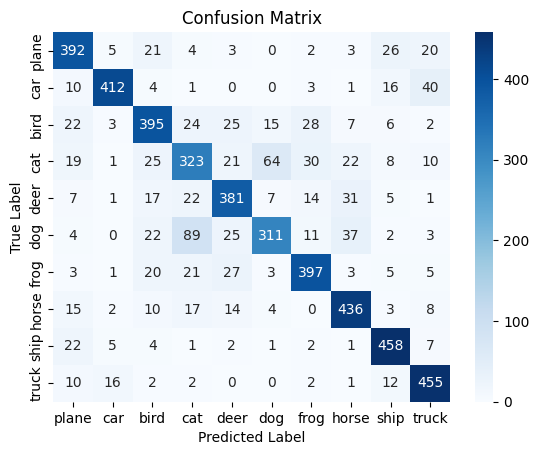

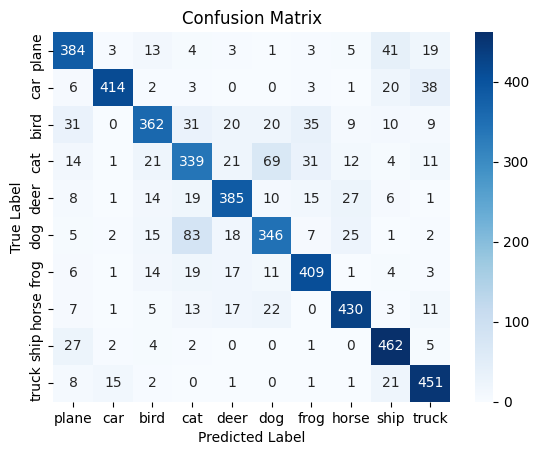

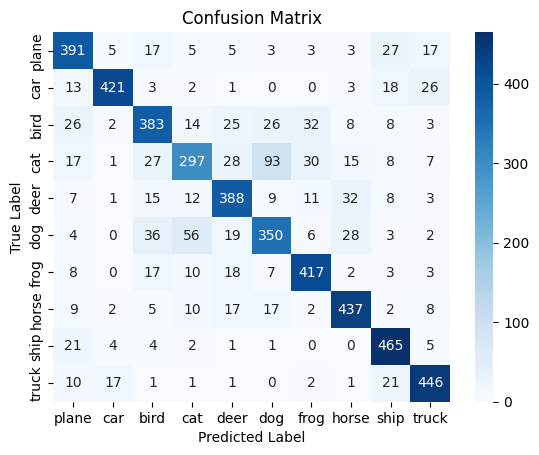

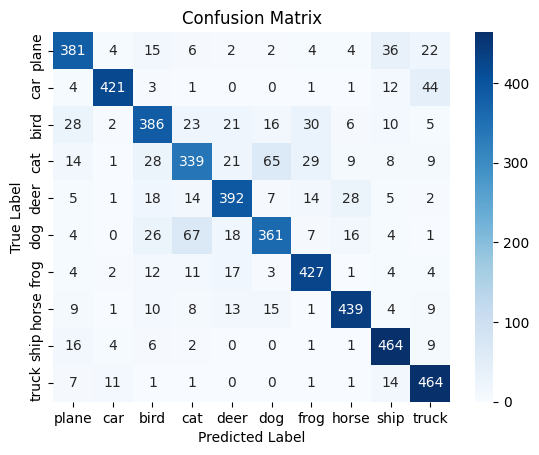

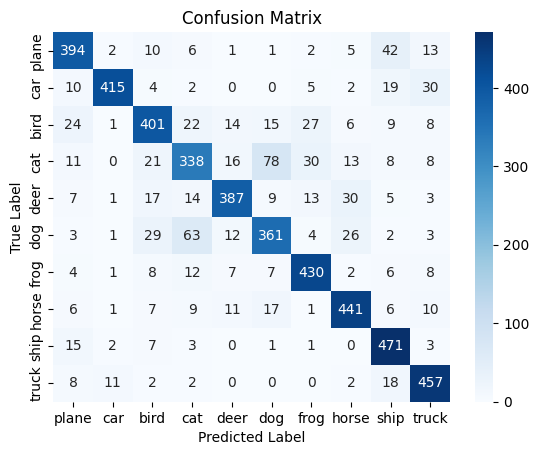

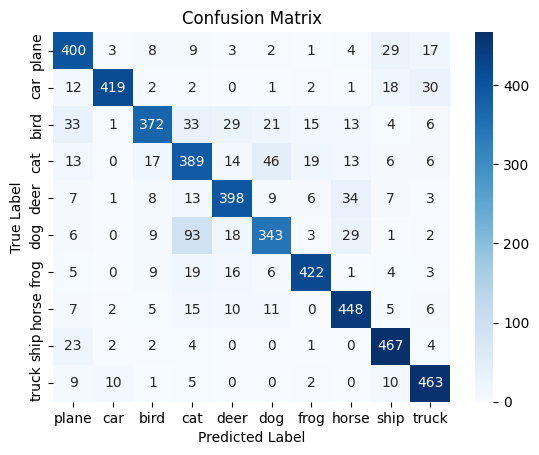

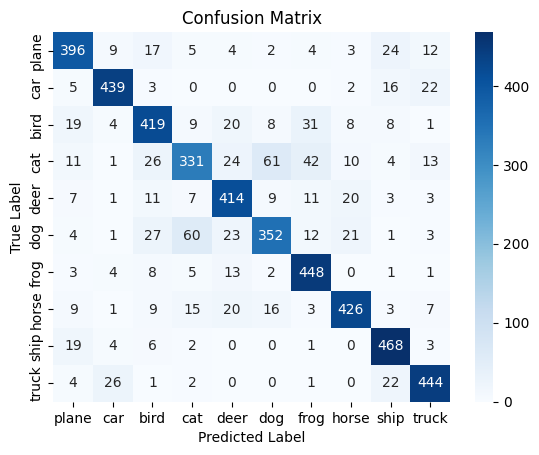

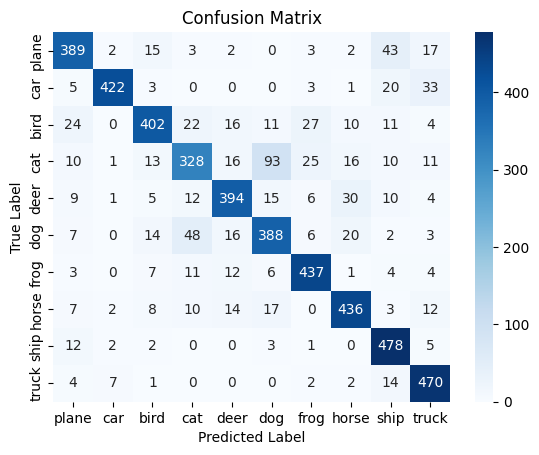

In [133]:
generate_confusion_matrices('third_model', true_labels3, predicted_labels3, classes)

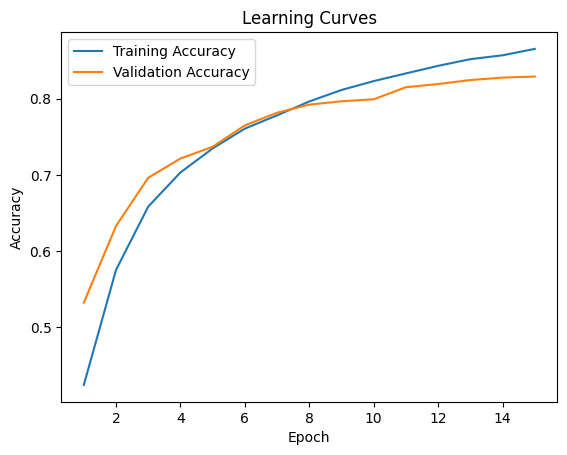

In [134]:
plot_learning_curves(epochs,training_accuracy3,validation_accuracy3)

In [135]:
PATH = './cifar_net3.pth'
torch.save(net3.state_dict(), PATH)

Test:

In [136]:
test_loader = get_test_loader('./data', batch_size=128, shuffle=True, num_workers=4, pin_memory=False)

In [137]:
test(test_loader,net3)

Accuracy on the test set is: 82 %
